In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
import matplotlib

# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

plt.rcdefaults()



from sklearn.metrics import roc_curve, auc, recall_score
from sklearn.metrics import precision_recall_curve
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import TomekLinks
from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN


In [59]:
data = pd.read_csv('data/sim_with_razor_extended.csv')
data = data.dropna()
data = data.drop('Event Number', axis=1)

In [12]:
X = data.drop('Dark Photon Produced', axis=1)
y = data['Dark Photon Produced'].astype(int) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [61]:
correlation_matrix = data.corr()
correlations_with_target = correlation_matrix['Dark Photon Produced'].drop('Dark Photon Produced')
sorted_correlations = correlations_with_target.abs().sort_values(ascending=False)
sorted_correlations

MET                    0.005333
Centrality             0.004579
HT                     0.004568
Sum E_T                0.004568
Aplanarity             0.004498
Sphericity             0.004382
Invariant Mass         0.004342
MR                     0.004342
Delta R (Avg)          0.004303
Rsq                    0.003889
Jet Multiplicity       0.000124
Lepton Multiplicity    0.000057
Cos(Theta) Jet-MET     0.000012
Name: Dark Photon Produced, dtype: float64

In [104]:
tomek_links = TomekLinks()
adasyn = ADASYN(random_state=42)
pipeline = SMOTEENN(random_state=42)

X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

In [105]:
y_resampled.value_counts()

Dark Photon Produced
1    399980
0    397452
Name: count, dtype: int64

In [16]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
}
grid_search = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid=param_grid, scoring='recall', cv=3)
grid_search.fit(X_resampled, y_resampled)

/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:44:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:44:15] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:44:16] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:44:17] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/homebrew/lib/python3.11/site-packages/x

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.7, 0.8, 1.0]},
             scoring='recall')

In [106]:
best_params = grid_search.best_params_
print("Best hyperparameters found by GridSearchCV:", best_params)

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

class_weights = {0: 1, 1: 0.2}  # Adjust these values

final_model = XGBClassifier(**best_params, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1)

final_model.fit(X_resampled, y_resampled, sample_weight=np.where(y_resampled == 1, class_weights[1], class_weights[0]))
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

Best hyperparameters found by GridSearchCV: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


/opt/homebrew/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:56:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [107]:
def calculate_metrics_vectorized(y_true, y_prob, thresholds):
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)
    
    y_pred_matrix = (y_prob[:, np.newaxis] >= thresholds).astype(int)
    
    tp = np.sum((y_pred_matrix == 1) & (y_true[:, np.newaxis] == 1), axis=0)
    fp = np.sum((y_pred_matrix == 1) & (y_true[:, np.newaxis] == 0), axis=0)
    fn = np.sum((y_pred_matrix == 0) & (y_true[:, np.newaxis] == 1), axis=0)
    tn = np.sum((y_pred_matrix == 0) & (y_true[:, np.newaxis] == 0), axis=0)
    
    recalls = tp / (tp + fn)
    false_positive_rates = fp / (fp + tn)
    
    return recalls, false_positive_rates

thresholds = np.linspace(0, 1, 1000)

recalls, false_positive_rates = calculate_metrics_vectorized(y_test, y_prob, thresholds)
valid_indices = np.where(recalls >= 0.6)[0]

if valid_indices.size > 0:
    min_fpr_index = valid_indices[np.argmin(false_positive_rates[valid_indices])]
    optimal_threshold = thresholds[min_fpr_index]
    min_false_positive_rate = false_positive_rates[min_fpr_index]
else:
    optimal_threshold = None
    min_false_positive_rate = None

optimal_threshold, min_false_positive_rate


(0.5225225225225225, 0.019640982049102456)

In [108]:
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

In [109]:
conf_matrix_weighted= confusion_matrix(y_test, y_pred_optimal)
print(conf_matrix_weighted)

[[98031  1964]
 [    2     3]]


In [110]:
class_report_weighted = classification_report(y_test, y_pred)
print(class_report_weighted)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     99995
           1       0.00      0.60      0.00         5

    accuracy                           0.98    100000
   macro avg       0.50      0.79      0.50    100000
weighted avg       1.00      0.98      0.99    100000



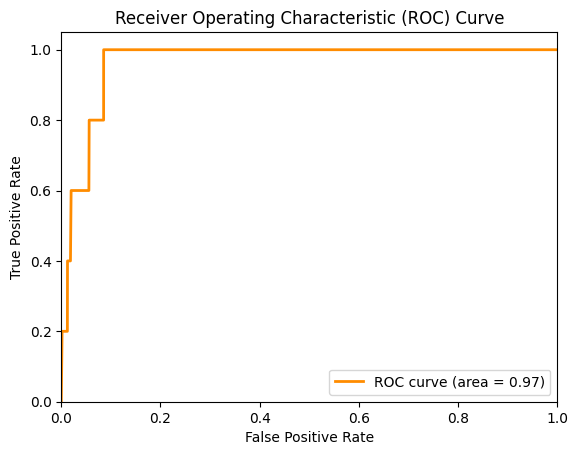

In [122]:


 # Probability estimates for the positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

%matplotlib inline
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")


plt.show()

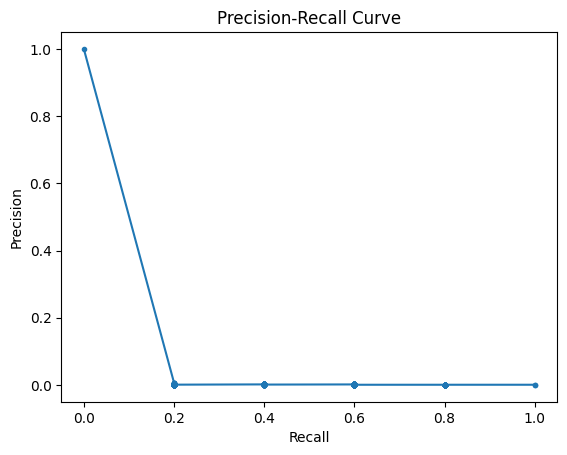

In [123]:
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)

%matplotlib inline
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

In [116]:
X_test_positive = X_test[y_pred == 1]
y_test_positive = y_test[y_pred == 1]


secondary_labels = y_test_positive.copy()
secondary_labels = secondary_labels.astype(int)  # Ensure integer type

class_counts = secondary_labels.value_counts()
minority_class = class_counts.idxmin()
n_samples = class_counts.min()

In [118]:
k_neighbors = max(1, n_samples - 1)  # Ensure k_neighbors <= n_samples - 1
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
under = RandomUnderSampler(random_state=42)
resampling_pipeline = Pipeline([
    ('smote', smote),
    ('under', under)
])
X_secondary_resampled, y_secondary_resampled = resampling_pipeline.fit_resample(X_test_positive, secondary_labels)

In [119]:
secondary_model = RandomForestClassifier(n_estimators=100, random_state=42)
secondary_model.fit(X_secondary_resampled, y_secondary_resampled)

# Predict with the secondary model
secondary_pred = secondary_model.predict(X_test_positive)

# Final predictions: only keep positives confirmed by the secondary model
final_predictions = y_pred.copy()
final_predictions[y_pred == 1] = secondary_pred


Classification Report for Two-Stage Model:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     99995
           1       1.00      0.60      0.75         5

    accuracy                           1.00    100000
   macro avg       1.00      0.80      0.87    100000
weighted avg       1.00      1.00      1.00    100000

Confusion Matrix for Two-Stage Model:
[[99995     0]
 [    2     3]]


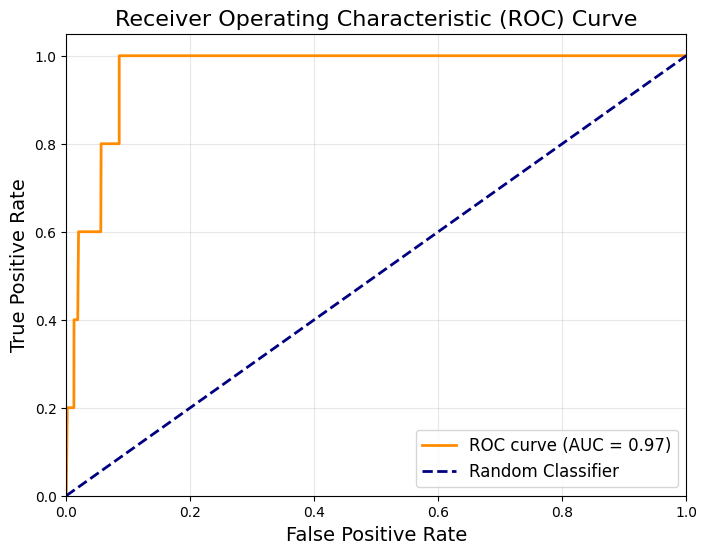

In [124]:
print("Classification Report for Two-Stage Model:")
print(classification_report(y_test, final_predictions))

conf_matrix = confusion_matrix(y_test, final_predictions)
print("Confusion Matrix for Two-Stage Model:")
print(conf_matrix)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.show()